In [25]:
import os
import pandas as pd
import datetime
from epiweeks import Week, Year
import re
import seaborn as sns


In [32]:
#make empty dataframe
df = pd.DataFrame(columns = ['mmwr_enddate', 'ppt (mm)', 'tmin (degrees C)', 'tmean (degrees C)','tmax (degrees C)', 'county'])

#path=r'C:\Users\Maria\Dropbox (Personal)\DS4A\Datasets\Current\Climate CA'
path=r'C:\Users\Maria\Dropbox (Personal)\DS4A\DS4A_ProjectFiles\Data\Climate_CA_short'


#fill with loop of files
 
for file in os.listdir(path):  
    county_name=file[6:len(file)-4]
    
    temp_df=pd.read_csv(path+"/"+file, skiprows=10)

    temp_df['mmwr_enddate']=pd.to_datetime(temp_df['Date'])
    temp_df.drop(columns=['Date'])
    new=temp_df.resample('w', on='mmwr_enddate',closed='left').mean()
    
    new['county']=county_name
    
    new.reset_index(inplace=True)

    df=df.append(new, ignore_index = True)
    #print(df)


#fix shift in end_date
day=datetime.timedelta(1)
df['mmwr_enddate']=df['mmwr_enddate']-day

df.rename(columns={'tmin (degrees C)':'tmin (C)', 'tmean (degrees C)':'tmean (C)','tmax (degrees C)':'tmax (C)'},inplace=True)
df

,mmwr_enddate,ppt (mm),tmin (C),tmean (C),tmax (C),county
0,2006-01-07,9.561429,5.457143,10.342857,15.228571,alameda
1,2006-01-14,1.148571,3.728571,9.557143,15.385714,alameda
2,2006-01-21,3.211429,2.857143,8.000000,13.114286,alameda
3,2006-01-28,0.437143,3.257143,8.657143,14.100000,alameda
4,2006-02-04,2.841429,6.414286,11.185714,15.928571,alameda
...,...,...,...,...,...,...
46849,2021-09-04,0.000000,15.271429,24.242857,33.157143,yuba
46850,2021-09-11,0.127143,18.628571,27.285714,35.871429,yuba
46851,2021-09-18,0.000000,15.728571,24.042857,32.300000,yuba
46852,2021-09-25,0.371429,15.114286,23.185714,31.214286,yuba


In [14]:
#Check Duplicates: Found none
#df[df.duplicated()]

,mmwr_enddate,ppt (mm),tmin (degrees C),tmean (degrees C),tmax (degrees C),county


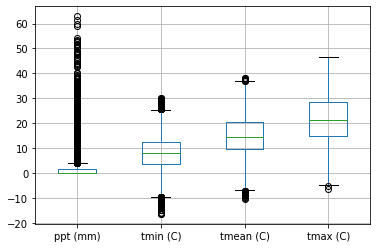

In [33]:
#df.isna().any().any() #false

#df.isnull().sum()
#no missing values

#df.county.value_counts() 
#822 of each

boxplot = df.boxplot(column=['ppt (mm)', 'tmin (C)', 'tmean (C)', 'tmax (C)'])
#sns.boxplot(x=df['ppt (mm)'])


In [12]:
#wnv= pd.DataFrame(columns = ['year', 'mmwr_week', 'county', 'case_count'])
path2=r'C:\Users\Maria\Dropbox (Personal)\DS4A\Datasets\Current\WNV_CA.csv'

wnv=pd.read_csv(path2, header=None)
wnv.columns=['year', 'mmwr_week','county','case_count']

#fix typos
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2010) ),'mmwr_week']=52
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2012) ),'mmwr_week']=52
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2013) ),'mmwr_week']=52
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2017) ),'mmwr_week']=52
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2018) ),'mmwr_week']=52
wnv.loc[((wnv.mmwr_week == 53) & (wnv.year == 2019) ),'mmwr_week']=52

#function to find enddate, if week 53, there are two special cases
def end_date(y,w):
    if w==53:
        if y==2008:
            return datetime.datetime(2009,1,3)
        elif y==2020:
            return datetime.datetime(2021,1,2)
        else:
            pass
    else:
        week=Week(y,w)
        return week.enddate()

#use year and mmwr_week to correlate to CDC mmwr end_date
wnv['mmwr_enddate']=wnv.apply(lambda x: end_date(x.year, x.mmwr_week), axis=1)

#sum the duplicate rows and clean string case
wnv_clean = wnv.groupby(['mmwr_enddate','year', 'mmwr_week', 'county']).sum()
wnv_clean.reset_index(inplace=True)
wnv_clean['county']=wnv_clean['county'].str.lower()

#replace county names
wnv_clean.county = wnv_clean.county.replace({
    'santa barbara':'santa_barbara',
    'santa clara':'santa_clara',
    'santa cruz':'santa_cruz',
    'san benito':'san_benito',
    'san bernadino':'san_bernadino',
    'san francisco':'san_francisco',
    'san joaquin':'san_joaquin',
    'san luis obispo':'san_luis_obispo',
    'san mateo':'san_mateo',
    'contra costa':'contra_costa',
    'del norte':'del_norte',
    'el dorado':'el_dorado',
    'los angeles':'los_angeles'   
})

#drop mmwr_week
wnv_clean=wnv_clean.drop(columns=['mmwr_week'])
wnv_clean

,mmwr_enddate,year,county,case_count
0,2006-06-24,2006,kern,1
1,2006-07-22,2006,kern,1
2,2006-07-22,2006,san_joaquin,1
3,2006-07-22,2006,stanislaus,1
4,2006-07-22,2006,sutter,1
...,...,...,...,...
2117,2021-09-18,2021,tulare,2
2118,2021-09-25,2021,fresno,1
2119,2021-09-25,2021,los_angeles,5
2120,2021-09-25,2021,stanislaus,2


In [23]:
#No Duplicates
#wnv_clean[wnv_clean.duplicated()]

#Checking for missing values
#df.isnull().sum()
#wnv_clean.isna().any().any() #false

wnv_clean.county.value_counts() 

los_angeles        229
kern               167
stanislaus         159
orange             136
riverside          135
fresno             129
san bernardino     113
san_joaquin         97
butte               95
sacramento          92
tulare              83
san diego           63
yolo                61
glenn               52
contra_costa        49
placer              42
merced              41
sutter              41
madera              41
yuba                35
kings               34
tehama              30
santa_clara         28
shasta              25
ventura             21
colusa              18
solano              17
imperial            14
lake                 9
el_dorado            8
alameda              8
mendocino            5
san_luis_obispo      5
napa                 4
marin                4
nevada               4
monterey             4
san_francisco        4
amador               4
santa_barbara        3
inyo                 3
modoc                2
siskiyou             2
mono       

In [16]:
wnv_clean.isna().any().any()

False

In [8]:
wnv_clean.dtypes

mmwr_enddate    datetime64[ns]
county                  object
case_count               int64
year                     int64
dtype: object